In [ ]:
!pip install qiskit
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 17.3 MB/s eta 0:00:00


#Deutsch's Algorithm

Deutsch's algorithm allows us to perform a task using fewer queries quantumly than are needed classically.

**Given**: 1-bit function f : {0,1} $\rightarrow$ {0,1}

**Function outputs**:

| Function ($f$) |   $f$(0)    | $f$(1) |
| --- | -------- | -------- |
| `constant_zero`| 0 | 0|
| `constant_one` | 1| 1 |
| `balanced_id` | 0| 1 |
| `balanced_not`| 1 | 0 |

**Problem**: Find if the function is Constant (*C*) or Balanced (*B*) in minimum number of queries.

*C*: All f(x) are equal: f(0) = f(1)

*B*: Equal number of 0's and 1's: f(0) = f(1).

The two "constant" functions output the same value no matter the input, whereas the balanced functions output different values for each input.

**Classical solution**: Run the machine twice, with inputs 0 and 1.

**Deutsch's Quantum Solution**: Run the machine only ONCE!

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

#Import qiskit libraries
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/dist-packages/qiskit/__init__.py)

> ***Step 1 - Initialization:*** Create quantum circuit with initial state 01 for function input. Prepare equal superposition (apply Hadamard gate) of both qubits.

In [ ]:
#Initialize QuantumRegister with two qubits
q = QuantumRegister(2,'q')

#Initialize ClassicalRegister with one bit
c = ClassicalRegister(1,'c')

#Initialize the circuit
circuit = QuantumCircuit(q, c)

#Reset all qubits

circuit.reset(q)
#Create initial state by applying X gate on q[1]

circuit.x(q[1])
#Create superpositions by applying H gate on both qubits
circuit.h([0,1])

#Visualize the circuit
circuit.draw()

┌───┐     
q_0: ─|0>─┤ H ├─────
          ├───┤┌───┐
q_1: ─|0>─┤ X ├┤ H ├
          └───┘└───┘
c: 1/═══════════════

We are given a black box that we know implements one of: `constant_zero`, `constant_one`, `balanced_id`, `balanced_not`. We are allowed to query the box (i.e. ask for $f(x)$ for either $x= 0, 1$) as many times as we need. _How many queries are needed to determine with certainty which function the box implements_?
### Classical solution

We _must_ query twice. For example, if we query $f(0)$ and receive $0$, we know we must have `constant_zero` or `balanced_id`, but we still can't pin down the exact function without querying a second time.  

### Quantum solution

We can perform this task with only a _single_ query using two qubits. Let's see how.

> ***Step 2 - The Oracle:*** Apply the oracle circuit, f(x), on the prepared initial states.

Let's choose one of the four functions randomly.

In this step, we are selecting a function at random out of the four possible options described above. Depending on the function selected, we build the oracle circuit. If the selected function is constant zero then we do nothing.

In [ ]:
function_names = ['constant_zero', 'constant_one', 'balanced_id', 'balanced_not']
oracle = function_names[np.random.randint(4)] #This statement chooses a random function from the above function_names

circuit.barrier()
if oracle == 'constant_one':
  #Apply X gate on q[1]
  circuit.x(q[1])


elif oracle == 'balanced_id':
  #Apply CNOT gate with control as q[0] and target as q[1]
  circuit.cnot(q[0],q[1])


elif oracle == 'balanced_not':
  #Apply X gate at q[0]
  circuit.x(q[0])


  #Apply CNOT gate with control as q[0] and taget as q[1]
circuit.cnot(q[0], q[1])

<ipython-input-5-b1a098b6e4b7>:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.cx as direct replacement.
  circuit.cnot(q[0], q[1])


At this moment we do not know which function was selected. To find out what function comprises the oracle, we perform measurement.


> ***Measurement:*** We perform measurement on one of the qubits after applying a Hadamard gate.

In [ ]:
circuit.barrier()

#Apply H gate to q[0]
circuit.h(q[0])


#Aplly measurement to q[0] and map it to c[0]
circuit.measure(q[0], c[0])


In [ ]:
# Execute the circuit a single time to get the measurement outcome
backend = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend, shots = 2).result()
counts = result.get_counts()

print("Measurement output counts:",counts)

#The following code checks the measurement results and states if the function is constant or balanced
if list(counts.keys())[0] == '0':
    print("Measured qubit in state |0>, function is constant.")
else:
    print("Measured qubit in state |1>, function is balanced.")

<ipython-input-7-770de07493ee>:2: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')
<ipython-input-7-770de07493ee>:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(circuit, backend, shots = 2).result()


Measurement output counts: {'1': 2}
Measured qubit in state |1>, function is balanced.


We just needed to measure one qubit to find out what type of function we have!

We can easily check if we were right. Let's see which function the oracle had chosen to implement. We can verify the function by simply printing the variable oracle and/or explicitly drawing the circuit.

In [ ]:
print("Selected oracle was",oracle)
circuit.draw()

Selected oracle was balanced_not


┌───┐      ░ ┌───┐      ░ ┌───┐┌─┐
q_0: ─|0>─┤ H ├──────░─┤ X ├──■───░─┤ H ├┤M├
          ├───┤┌───┐ ░ └───┘┌─┴─┐ ░ └───┘└╥┘
q_1: ─|0>─┤ X ├┤ H ├─░──────┤ X ├─░───────╫─
          └───┘└───┘ ░      └───┘ ░       ║ 
c: 1/═════════════════════════════════════╩═
                                          0

#Deutsch-Josza Algorithm

Generalisation of the Deutsch's algorithm to *n* qubits is the Deutsch-Josza Algorithm. Here, we create a circuit to simulate Deutsch-Jozsa algorithm with balanced f(x) output for 3 qubits. We will also run this on a quantum computer.

In [ ]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit1 = QuantumCircuit(qreg_q, creg_c)

#Reset all qubits
circuit1.reset(qreg_q[0])
circuit1.reset(qreg_q[1])
circuit1.reset(qreg_q[2])

#Apply H gates on all qubits
circuit1.h(qreg_q[0])
circuit1.h(qreg_q[1])
circuit1.h(qreg_q[2])


#Oracle for balanced function
circuit1.barrier(qreg_q[0])
circuit1.barrier(qreg_q[1])
circuit1.barrier(qreg_q[2])
circuit1.z(qreg_q[0])
circuit1.barrier(qreg_q[0])
circuit1.h(qreg_q[2])
circuit1.cx(qreg_q[1], qreg_q[2])
circuit1.barrier(qreg_q[1])
circuit1.h(qreg_q[2])
circuit1.barrier(qreg_q[2])

#Apply H gates on all qubits
circuit1.h(qreg_q[0])
circuit1.h(qreg_q[1])
circuit1.h(qreg_q[2])





#Apply measurement on all qubits
circuit1.measure_all()





#Visualize the circuit
circuit1.draw()

┌───┐ ░ ┌───┐  ░  ┌───┐           ░ ┌─┐      
   q_0: ─|0>─┤ H ├─░─┤ Z ├──░──┤ H ├───────────░─┤M├──────
             ├───┤ ░ └───┘  ░  └─░─┘┌───┐      ░ └╥┘┌─┐   
   q_1: ─|0>─┤ H ├─░────────■────░──┤ H ├──────░──╫─┤M├───
             ├───┤ ░ ┌───┐┌─┴─┐┌───┐└─░─┘┌───┐ ░  ║ └╥┘┌─┐
   q_2: ─|0>─┤ H ├─░─┤ H ├┤ X ├┤ H ├──░──┤ H ├─░──╫──╫─┤M├
             └───┘ ░ └───┘└───┘└───┘  ░  └───┘ ░  ║  ║ └╥┘
   c: 3/══════════════════════════════════════════╬══╬══╬═
                                                  ║  ║  ║ 
meas: 3/══════════════════════════════════════════╩══╩══╩═
                                                  0  1  2

<ipython-input-10-70cd44ffa7ed>:4: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circuit1, simulator, shots=50) #Change number of shots to get different outputs


Success?  True
Status:  COMPLETED


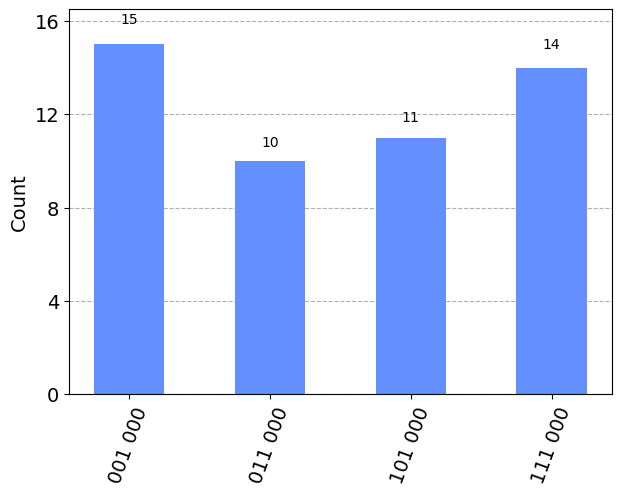

In [ ]:
##qasm_simulator backend

simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit1, simulator, shots=50) #Change number of shots to get different outputs
result = job.result()
print("Success? ", result.success)
print("Status: ", result.status)
counts = result.get_counts(circuit1)
plot_histogram(counts)

<ipython-input-11-16396ef5db13>:4: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circuit1, simulator, shots=500)


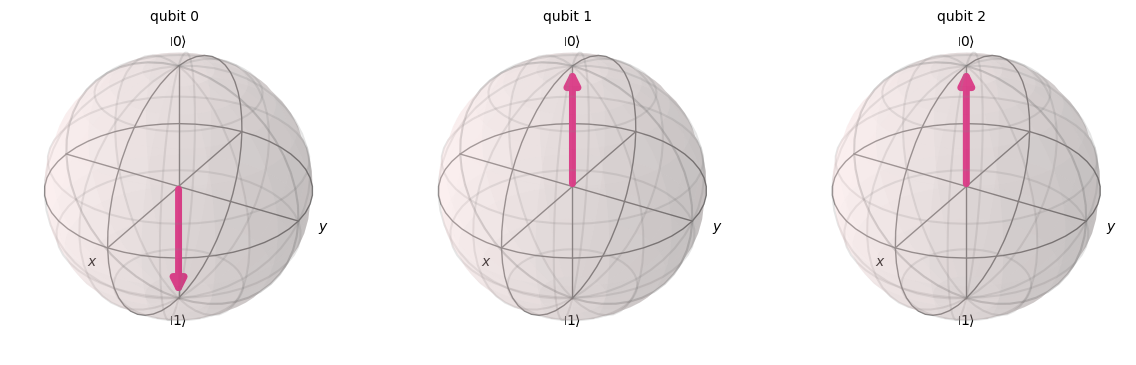

In [ ]:
##statevector_simulator backend

simulator = Aer.get_backend('statevector_simulator')
job = execute(circuit1, simulator, shots=500)
result = job.result()
counts = result.get_counts(circuit1)
plot_bloch_multivector(result.get_statevector())

In [ ]:
!pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.


In [ ]:
# Enter IBM API token here
IBMQ.save_account('037d058b6369da27efc3051710a5855dcf8e5acbf1f1a07b61dd607679e472a4c11d839f6df22e0e7b9718f28a07268d62b2ca57a6409432c6e842fd21f08063',overwrite=True)
IBMQ.load_account()

##Run on quantum computer
start_time=time.time()

from qiskit.providers.ibmq import least_busy
shots = 500

# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit1
job = execute(circuit1, backend=backend, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

least busy backend:  ibm_osaka


<ipython-input-14-fac7d62ad718>:18: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circuit1, backend=backend, shots=shots)


Job Status: job has successfully run


In [ ]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator

# Define the balanced oracle function (CNOT gate)
def balanced_oracle(qc):
    qc.cx(0, 1)

# Define the constant oracle function (X gate)
def constant_oracle(qc):
    qc.x(1)

# Implement the Deutsch-Jozsa algorithm
def deutsch_jozsa_algorithm(oracle):
    # Initialize quantum circuit with two qubits
    qc = QuantumCircuit(2, 2)

    # Apply Hadamard gates to both qubits
    qc.h(0)
    qc.h(1)

    # Apply the oracle function
    oracle(qc)

    # Apply Hadamard gates again
    qc.h(0)
    qc.h(1)

    # Measure both qubits
    qc.measure([0, 1], [0, 1])

    return qc

# Create a quantum circuit for the balanced oracle function
balanced_circuit = deutsch_jozsa_algorithm(balanced_oracle)
print("Circuit for Balanced Oracle:")
print(balanced_circuit.draw())

# Create a quantum circuit for the constant oracle function
constant_circuit = deutsch_jozsa_algorithm(constant_oracle)
print("Circuit for Constant Oracle:")
print(constant_circuit.draw())


Circuit for Balanced Oracle:
     ┌───┐     ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ H ├┤M├───
     ├───┤┌─┴─┐├───┤└╥┘┌─┐
q_1: ┤ H ├┤ X ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 
Circuit for Constant Oracle:
     ┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├┤ H ├─────┤M├───
     ├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ H ├┤ X ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 


<ipython-input-15-349c8477ca76>:3: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer import AerSimulator


What are your observations from the output of the quantum computer and/or the simulator?